# Curso: MCC639E

#### Integrantes

- Carlos Tello Tapia
- Lennin Quiso Córdova
- Milton Palacin Grijalva
___

# PARTE PARTE: TEXT SUMMARIZATION

## I. Declaración de librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Tratamiento de texto
# ==============================================================================

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras import backend as K

# Visualización Jupyter
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Configuración matplotlib
# ==============================================================================
# Para obtener el estilo de plot de seabonr
plt.style.use('seaborn-whitegrid')
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"

## II. Cargar y explorar el dataset

In [2]:
%%time
dataset_base = pd.read_csv("dataset_base.csv", sep='\t', encoding='utf-8')
dataset_base.sample(5)

CPU times: user 983 ms, sys: 88.2 ms, total: 1.07 s
Wall time: 1.07 s


,category,title,date,abstract,content,content_for_summary,abstract_for_summary,content_for_topic,content_for_topic_lemma
3770,TRANSPORTES Y COMUNICACIONES,RESOLUCION MINISTERIAL N° 499-2021-MTC/01.02,29/05/2021,Aprueban ejecución de expropiación de área de ...,"Lima, 27 de mayo de 2021 VISTO: El Memorándum ...",lima de mayo de visto el memorándum mtc de la ...,aprueban ejecución de expropiación de área de ...,lima mayo visto memorándum dirección ejecutiva...,lima mayo visto memorándum dirección ejecutivo...
3952,TRANSPORTES Y COMUNICACIONES,RESOLUCION MINISTERIAL N° 477-2021-MTC/01.02,26/05/2021,Aprueban ejecución de expropiación de área de ...,"Lima, 24 de mayo de 2021 VISTA: La Nota de Ele...",lima de mayo de vista la nota de elevación mtc...,aprueban ejecución de expropiación de área de ...,lima mayo vista nota elevación dirección ejecu...,lima mayo visto nota elevación dirección ejecu...
1733,MUNICIPALIDAD DE SAN BORJA,DECRETO DE ALCALDIA N° 008-2021-MSB-A,12/07/2021,Disponen el embanderamiento general del distrito,"San Borja, 7 de julio de 2021 EL ALCALDE DE LA...",san borja de julio de el alcalde de la municip...,disponen el embanderamiento general del distrito,borja julio alcalde municipalidad distrital bo...,borjo julio alcalde municipalidad distrital bo...
1325,BIBLIOTECA NACIONAL DEL PERU,RESOLUCION JEFATURAL N° 000080-2021-BNP,21/07/2021,Crean la Red de Bibliotecas Públicas Municipal...,"Lima, 20 de julio de 2021 VISTOS: El Informe N...",lima de julio de vistos el informe bnp ddpb de...,crean la red de bibliotecas públicas municipales,lima julio vistos informe ddpb fecha junio dir...,lima julio visto informe ddpb fecha junio dire...
3497,ORGANISMO SUPERVISOR DE INVERSION PRIVADA EN T...,RESOLUCION N° 088 -2021-CD/OSIPTEL,04/06/2021,Declaran infundado recurso de apelación interp...,"Lima, 1 de junio de 2021 VISTOS: (i) El Recu...",lima de junio de vistos el recurso de apelació...,declaran infundado recurso de apelación interp...,lima junio vistos recurso apelación interpuest...,lima junio visto recurso apelación interpuesto...


___
Utilizar las columnas: 
* **content_for_summary**
* **abstract_for_summary**

Estas columnas a diferencia de **content_for_topic** son textos pre-procesados sin stemmer o lemmatizer. Es necesario mantener la palabras originales para ayudar a la red a mejorar la exactitud en la generación del "summary" 
___

In [3]:
print("Total de normas legales en el dataset:", dataset_base.shape[0])

Total de normas legales en el dataset: 4037


___
Agregar la palablas (tokens) especiales al inicio y fin del abstract
___

In [4]:
%%time
# Función para marcar el texto que servira al Decoder del modelo Seq2Seq
dataset_base.abstract_for_summary = dataset_base.abstract_for_summary.apply(lambda t: "_START_ " + t + " _END_")
dataset_base.sample(5)

CPU times: user 2.28 ms, sys: 0 ns, total: 2.28 ms
Wall time: 2.05 ms


,category,title,date,abstract,content,content_for_summary,abstract_for_summary,content_for_topic,content_for_topic_lemma
3838,"CONSEJO NACIONAL DE CIENCIA, TECNOLOGIA E INNO...",RESOLUCION N° 052-2021-CONCYTEC-P,28/05/2021,Aprueban transferencias financieras a favor de...,"Lima, 21 de mayo de 2021 VISTOS: El Informe Té...",lima de mayo de vistos el informe técnico lega...,_START_ aprueban transferencias financieras fa...,lima mayo vistos informe técnico legal fondecy...,lima mayo visto informe técnico legal fondecyt...
2953,"CONSEJO NACIONAL DE CIENCIA, TECNOLOGIA E INNO...",RESOLUCION N° 060-2021-CONCYTEC-P,17/06/2021,Modifican el Clasificador de Cargos del Pliego...,"Lima, 16 de junio de 2021 VISTOS: El Informe N...",lima de junio de vistos el informe concytec og...,_START_ modifican el clasificador de cargos de...,lima junio vistos informe concytec oficina per...,lima junio visto informe concytec ogar oficina...
3956,ORGANISMO SUPERVISOR DE INVERSION PRIVADA EN T...,RESOLUCION N° 081 -2021-CD/OSIPTEL,26/05/2021,Declaran infundado el Recurso de Apelación int...,"Lima, 22 de mayo de 2021 VISTOS: (i) El Recu...",lima de mayo de vistos el recurso de apelación...,_START_ declaran infundado el recurso de apela...,lima mayo vistos recurso apelación interpuesto...,lima mayo visto recurso apelación interpuesto ...
2220,SEGURO INTEGRAL DE SALUD,RESOLUCION JEFATURAL N° 082-2021/SIS,01/07/2021,Aprueban Transferencia Financiera a favor de d...,"Lima, 1 de julio de 2021 VISTOS: El Informe Co...",lima de julio de vistos el informe conjunto si...,_START_ aprueban transferencia financiera favo...,lima julio vistos informe conjunto pmra vhsn p...,lima julio visto informe conjunto pmra vhsn pr...
762,CULTURA,RESOLUCION VICE MINISTERIAL N° 000181-2021-VM...,28/07/2021,Declaran Monumento integrante del Patrimonio C...,"San Borja, 26 de julio del 2021 VISTOS; el Inf...",san borja de julio del vistos el informe dgpc ...,_START_ declaran monumento integrante del patr...,borja julio vistos informe dgpc dirección gene...,borjo julio visto informe dgpc dirección gener...


___
Entender la distribución de las secuencias: anlizando el tamaño del contenido y el abstract. Este ejercicio ayuda a encontrar el tamaño máximo de las secuencias
___

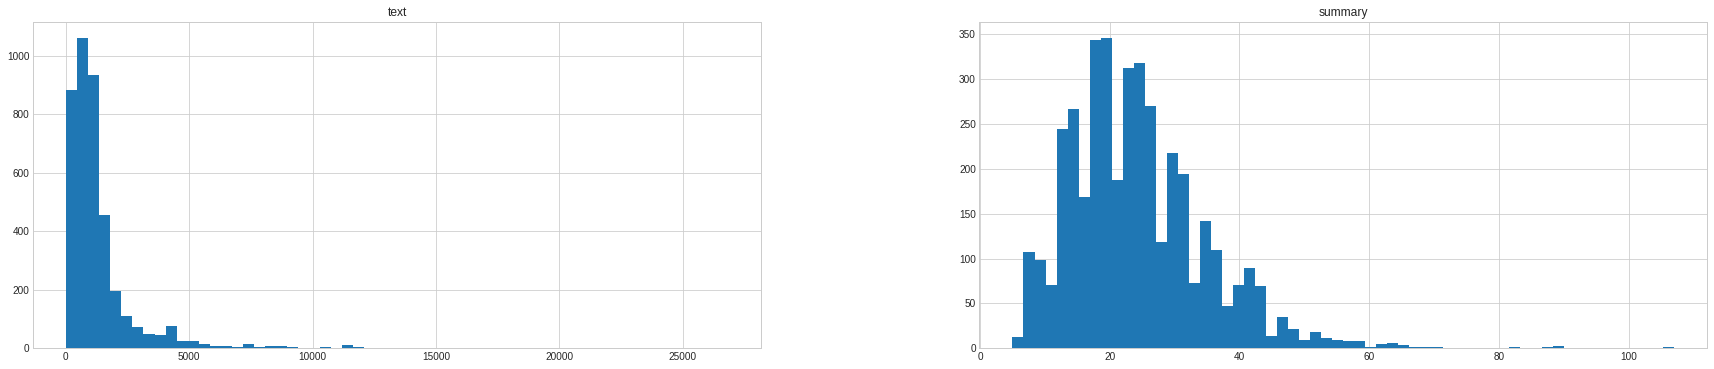

CPU times: user 550 ms, sys: 0 ns, total: 550 ms
Wall time: 549 ms


In [7]:
%%time
text_count = []
summary_count = []


for sent in dataset_base.content_for_summary:
    text_count.append(len(sent.split()))
for sent in dataset_base.abstract_for_summary:
    summary_count.append(len(sent.split()))

# Crear dataset para graficar histograma
graph_df = pd.DataFrame()
graph_df['content']=text_count
graph_df['summary']=summary_count

graph_df.hist(bins = 60, figsize=(30,6))
plt.show()

## III. Configurar dataset para dividir en el dataset de entranamiento y pruebas

___
Seleccionar el número máximo de secuencias (tokens-palabras) de acuero a la gráfica, de tal manera que concentre la mayor parte de contenido promedio y evitar los **outliers**.
___

In [9]:
%%time
# El modelo realizará las siguientes secuencias: abstract/summary entre 1-max_summary_len tokens y para contenido/content entre 1 y max_content_len tokesn.
max_len_content = 3000
max_len_summary = 35

print("="*50)

# Verificar el porcentaje de palabras en el content entre 1 y max_content_len
print("% content de palabras entre 1 y " + str(max_len_content) + ":",
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.content_for_summary.split()) > 100 and
                       len(v.content_for_summary.split()) <= 100 + max_len_content, axis=1)
            ].shape[0]/len(dataset_base.content_for_summary)
)

# Verificar el porcentaje de palabras en el abstract entre 1 y max_summary_len
print("% abstract de palabras entre 1 y " + str(max_len_summary) + ":",
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.abstract_for_summary.split()) > 5 and
                       len(v.abstract_for_summary.split()) <= 5 + max_len_summary, axis=1)
            ].shape[0]/len(dataset_base.abstract_for_summary)
)

print("="*50)

% content de palabras entre 1 y 3000: 0.9046321525885559
% abstract de palabras entre 1 y 35: 0.9202378003467921
CPU times: user 656 ms, sys: 14.5 ms, total: 671 ms
Wall time: 668 ms


___
Elegir secuencias mayores a 5 y menores a max_content_len, max_summary_len según sea el caso
___

In [11]:
%%time
dataset_pre = \
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.content_for_summary.split()) > 5 and
                       len(v.content_for_summary.split()) <= max_len_content and
                       len(v.abstract_for_summary.split()) > 5 and
                       len(v.abstract_for_summary.split()) <= max_len_summary, axis=1)
][["content_for_summary","abstract_for_summary"]]

dataset_pre.sample(5)

CPU times: user 691 ms, sys: 2.92 ms, total: 694 ms
Wall time: 692 ms


,content_for_summary,abstract_for_summary
889,que el ministerio de cultura creado por la ley...,_START_ decreto supremo que aprueba el reglame...
3088,lima de junio de vistos el informe mimp optp d...,_START_ designan director general de la oficin...
1618,lima de julio del visto el oficio cr ueti cpp ...,_START_ modifican la resolución administrativa...
893,lima de julio de vistos el informe minedu vmgi...,_START_ designan coordinador iii de gestión de...
1814,ate de julio del el concejo municipal del dist...,_START_ ordenanza que otorga beneficios tribut...


___
Dividir el dataset base en conjunto de entranamiento y pruebas
* $x\_tr\_i$, $y\_tr\_i$: datos (datasets) de entrenamiento
* $x\_val\_i$, $y\_val\_i$: datos (datasets) de validación
___

In [12]:
%%time
x_tr_i, x_val_i, y_tr_i, y_val_i = train_test_split(dataset_pre.content_for_summary.to_numpy(), dataset_pre.abstract_for_summary.to_numpy(), test_size=0.1, random_state=0, shuffle=True)
x_tr_i.shape, x_val_i.shape

CPU times: user 6.3 ms, sys: 0 ns, total: 6.3 ms
Wall time: 4.99 ms


((2901,), (323,))

## III. Tokenizar los dataset

___
<h3>Tratar palabras que aparecen raras veces</h3>  

____
Luego de tokenizar se revisará las  palabras que tiene menos uso, con la cantidad obtnida se vuelve a tokenizar para tomar el grupo más frecuente.

* total_token: tamaño del vocabulario, es decir conteo por palabras única.
* total_thresh: Umbral de la frecuencia mímima
* total_rare: cantidad de palabras (conteo po palabra) con una frecuencia menor al total_thresh.
* total_token -  total_thresh: determina el número de palabras más comunes
___

___
Preparar tokenizer para el contenido en los datos de entranamiento
___

In [14]:
%%time
# Preparar tokenizer para el contenido en los datos de entranamiento
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(x_tr_i)
total_thresh = 5 # sin contar al _START_ y _END_

total_token = 0
total_rare  = 0
freq = 0
total_freq = 0

# Leer el diccionario
for key,value in x_tokenizer.word_counts.items():
    total_token = total_token + 1
    total_freq = total_freq + value
    if value < thresh:
        total_rare = total_rare + 1
        freq = freq + value


print("="*50)
print("% de palabras raras en el vocabulario:",(total_rare/total_token)*100)
print("Covertura todal de las palabras raras:",(freq/total_freq)*100)
print("="*50)

# Preparar tokenizer para el contenido en los datos de entranamiento
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(x_tr_i)

#Convertir la secuencias de texto en una secuencia de enteros (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr_i) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val_i)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_content, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_content, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))
len(x_tokenizer.word_counts)

% of rare words in vocabulary: 41.76464710388702
Total Coverage of rare words: 0.6242729971210313
Size of vocabulary in X = 17485
CPU times: user 7.37 s, sys: 4.3 ms, total: 7.37 s
Wall time: 7.4 s


30023

In [36]:
%%time
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(y_tr_i)



thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)


#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(y_tr_i)

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr_i) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val_i) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 60.200601805416255
Total Coverage of rare words: 5.602215734710682
Size of vocabulary in Y = 1985
CPU times: user 259 ms, sys: 525 µs, total: 260 ms
Wall time: 258 ms


In [99]:
%%time

K.clear_session()


latent_dim = 300
#embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_content_len,))

#embedding layer
enc_emb =  Embedding(x_voc, latent_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3000, 300)    5245500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 3000, 300),  721200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [100]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [101]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [102]:
y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:].shape, y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:].shape, len([x_tr,y_tr[:,:-1]][1]), len([x_val,y_val[:,:-1]][1])

((323, 34, 1), (2901, 34, 1), 2901, 323)

In [103]:
%%time
history=model.fit(
    [x_tr,y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], 
    epochs=3, callbacks=[es], batch_size=16, 
    validation_data= ([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/3
182/182 [==============================] - 324s 2s/step - loss: 3.0631 - val_loss: 2.5841
Epoch 2/3
182/182 [==============================] - 310s 2s/step - loss: 2.4756 - val_loss: 2.3025
Epoch 3/3
182/182 [==============================] - 289s 2s/step - loss: 2.1975 - val_loss: 2.0905
CPU times: user 13min 5s, sys: 2min 21s, total: 15min 27s
Wall time: 15min 22s


### 

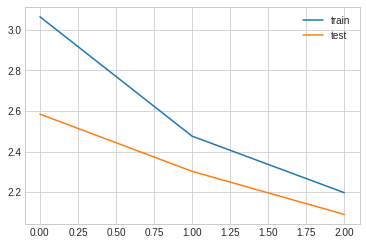

In [104]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [105]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [106]:
%%time
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_content_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

CPU times: user 445 ms, sys: 7.5 ms, total: 453 ms
Wall time: 451 ms


In [107]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['oooooo']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eeeeee'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eeeeee'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [108]:

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['oooooo']) and i!=target_word_index['eeeeee']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [109]:
#y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]
#y_val[0].shape[1]

In [ ]:

#encoder_model.predict(x_val[12].reshape(1,max_content_len))

In [ ]:
%%time
for i in range(12,15):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_content_len)))
    print("\n")

#     print("Review:",seq2text(x_tr[i]))
#     print("Original summary:",seq2summary(y_tr[i]))
#     print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_content_len)))
#     print("\n")